In [1]:
from Ornstein_Uhlenbeck import Ornstein_Uhlenbeck
from results_generator import *
from scipy.stats import norm
import backtrader as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfolio as pf

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
stock_list = ['SLV', 'SIL']
obs = 252
cash = 100000000
commission = 0.004
stock_dict = {}
for stock in stock_list:
    stock_dict[stock] = pd.read_csv('data/{}.csv'.format(stock), index_col='Date', parse_dates=['Date'])

In [3]:
class PandasData(bt.feeds.PandasData):
    lines = ('open', 'high', 'low', 'close', 'adjclose', 'volume')
    params = (('datetime', None),
              ('open', 0),
              ('high', 1),
              ('low', 2),
              ('close', 3),
              ('adjclose', 4),
              ('volume', 5))

In [4]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.obs = obs # number of observations used by the model
        self.n = 0 # number of days
        self.pos = 0 # initial position
        
        # model settings
        self.model = None
        self.a, self.b = 0, 1 # index of Sta and Stb
        self.s = 0 # used to update the EX and Var(X)
        self.dt = 1 / 252
        self.z = norm.ppf(0.99)
        
        # stop-loss
        self.sl = 1 # = 1 if stop-loss is added to the algo
        self.freeze = 0 # > 0 if stop-loss is triggered
        
        # logging the process
        self.date_list = []
        self.Xt_list = []
        self.lb_list = []
        self.ub_list = []

    def signal_generation(self):
        if self.model is None:
            return 0
        
        self.Xt = self.model.alpha * self.Sta[-1] - self.model.beta * self.Stb[-1]
        
        if self.freeze > 0:
            self.freeze -= 1
            return 0
        
        if self.pos == 1:
            if self.Xt >= self.EX + self.z * np.sqrt(self.VarX):
                return 0
            elif self.sl and self.Xt < self.Xs - self.z * np.sqrt(self.VarX):
                self.freeze += self.obs // 2
                print('Stoploss!')
                return 0
            else:
                return 1
        elif self.pos == -1:
            if self.Xt <= self.EX - self.z * np.sqrt(self.VarX):
                return 0
            elif self.sl and self.Xt > self.Xs + self.z * np.sqrt(self.VarX):
                self.freeze += self.obs // 2
                print('Stoploss!')
                return 0
            else:
                return -1
        else: # self.pos == 0
            if self.Xt > self.EX + self.z * np.sqrt(self.VarX):
                return -1
            elif self.Xt < self.EX - self.z * np.sqrt(self.VarX):
                return 1
            else:
                return 0
    
    def update_statistics(self):
        self.EX = self.model.mu + (self.X0 - self.model.mu) * np.exp(-self.model.theta * self.s * self.dt)
        self.VarX = self.model.sigma2 * (1 - np.exp(-2 * self.model.theta * self.s * self.dt)) / (2 * self.model.theta)
    
    def renew_model(self):
        model1 = Ornstein_Uhlenbeck(self.Sta, self.Stb)
        model2 = Ornstein_Uhlenbeck(self.Stb, self.Sta)
        if model1.l is None and model2.l is None:
            self.model = None
        elif model1.l is None and model2.l is not None:
            self.model = model2.l
            self.a, self.b = self.b, self.a
            self.Sta, self.Stb = self.Stb, self.Sta
        elif model1.l is not None and model2.l is None:
            self.model = model1.l
        else:
            if model1.l >= model2.l:
                self.model = model1
            else:
                self.model = model2
                self.a, self.b = self.b, self.a
                self.Sta, self.Stb = self.Stb, self.Sta
        if self.model is not None:
            self.X0 = self.model.alpha * self.Sta[-1] - self.model.beta * self.Stb[-1]
            self.s = 0
            self.update_statistics()
        
    def close_positions(self): # to close all existing positions
        for data in self.datas:
            self.close(data=data)
    
    def logging(self):
        self.date_list.append(self.data.datetime.date())
        self.Xt_list.append(self.Xt)
        self.lb_list.append(self.EX - self.z * np.sqrt(self.VarX))
        self.ub_list.append(self.EX + self.z * np.sqrt(self.VarX))

        if self.date_list[-1] == self.last_day:
            plt.figure(figsize=(10, 6))
            plt.plot(self.date_list, self.lb_list, label='Lower Bound')
            plt.plot(self.date_list, self.ub_list, label='Upper Bound')
            plt.plot(self.date_list, self.Xt_list, label=r'$X_t$')
            plt.legend()
    
    def start(self):
        self.last_day = self.data.datetime.date(-1)  # Get the last available date
        
    def next(self):
        self.Sta = np.array(self.datas[self.a].close.get(size=self.obs))
        self.Stb = np.array(self.datas[self.b].close.get(size=self.obs))
            
        self.n += 1
        if self.n == self.obs:
            self.renew_model()
            
        self.signal = self.signal_generation()
    
        if self.signal == 1:
            if self.pos == 0:
                self.buy(data=self.datas[self.a], size=cerebro.broker.get_value() * self.model.alpha)
                self.sell(data=self.datas[self.b], size=cerebro.broker.get_value() * self.model.beta)
                self.Xs = self.Xt
                print("{}: Long pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
                
        elif self.signal == -1:
            if self.pos == 0:
                self.sell(data=self.datas[self.a], size=cerebro.broker.get_value() * self.model.alpha)
                self.buy(data=self.datas[self.b], size=cerebro.broker.get_value() * self.model.beta)
                self.Xs = self.Xt
                print("{}: Short pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
                
        else: # self.signal == 0
            if self.pos != 0:
                self.close_positions()
                print("{}: Close pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
                self.renew_model()
                
        self.pos = self.signal
        
        if self.n >= self.obs:
            self.logging()
            self.s += 1 # update the statistics for the next day
            self.update_statistics()
            
            if self.pos == 0 and self.s >= self.obs // 2:
                self.renew_model()

In [5]:
# backtest settings
cerebro = bt.Cerebro()

data_feed_dict = {}
for stock in stock_list:
    data_feed_dict[stock] = PandasData(dataname=stock_dict[stock], name=stock)
    cerebro.adddata(data_feed_dict[stock])

cerebro.addstrategy(MyStrategy)
cerebro.broker.setcash(cash)
cerebro.broker.setcommission(commission=commission)

2015-01-22: Short pair when Xt = 0.5780609777810457
2016-05-19: Close pair when Xt = 0.4486687989746932
2016-08-08: Long pair when Xt = 0.48271946149266454
2019-08-30: Close pair when Xt = 0.6510490401866051
2019-09-03: Short pair when Xt = 0.7085108571399182
Stoploss!
2019-09-04: Close pair when Xt = 0.7334683463953484
2020-03-09: Short pair when Xt = 0.5418468688961224
2020-03-16: Close pair when Xt = 0.3961453989445695
2020-03-17: Long pair when Xt = 0.44530008954322053
2020-07-27: Close pair when Xt = 0.7716937412922276
2020-08-04: Short pair when Xt = 0.7412506346043297
Stoploss!
2020-08-06: Close pair when Xt = 0.896021428790111
2021-08-06: Long pair when Xt = 0.2450432921822593
2022-02-28: Close pair when Xt = 0.3432415313403796
2022-03-01: Short pair when Xt = 0.4760366808571608
Stoploss!
2023-05-02: Close pair when Xt = 0.53905716244899


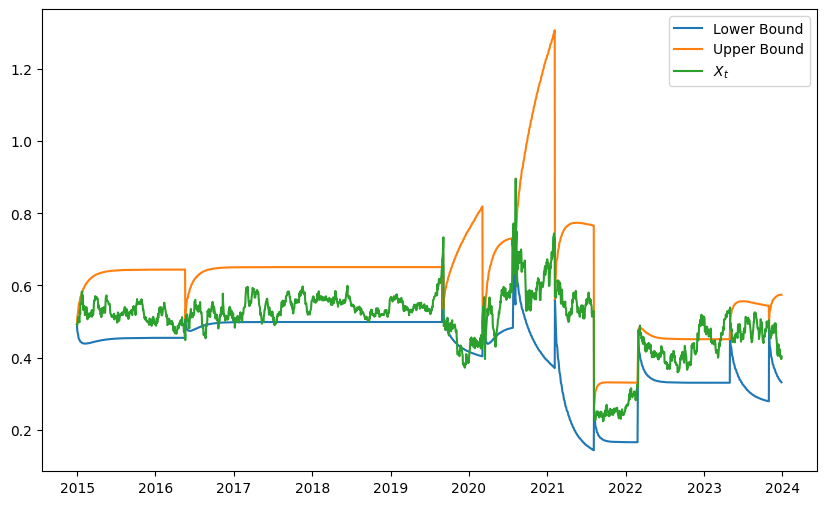

In [6]:
# Run the backtest
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

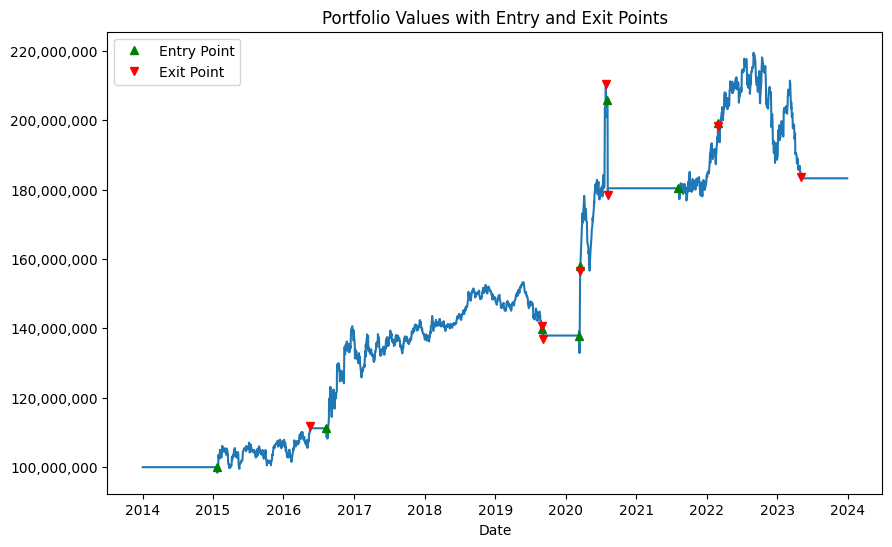

In [7]:
plot_portfolio_values(cash, returns, positions)

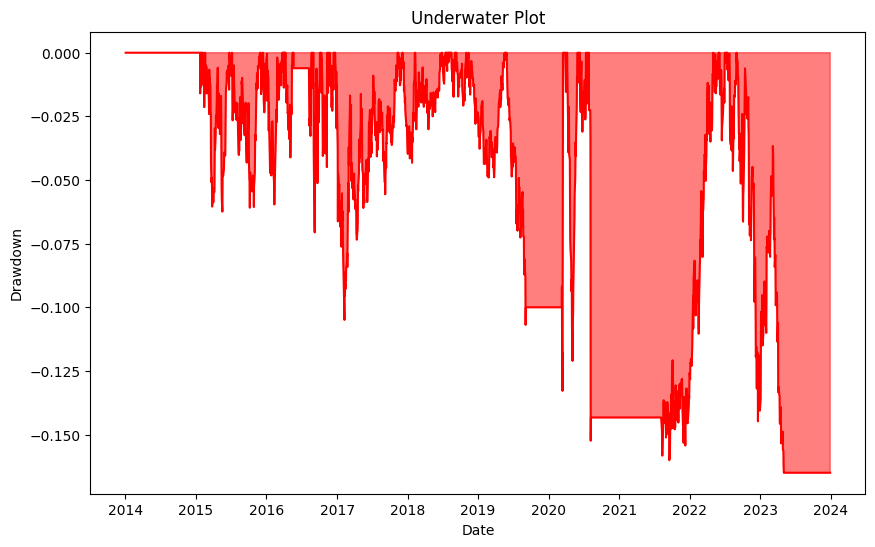

In [8]:
plot_underwater(returns)

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib

                    In-sample Out-of-sample         All
Annual return            0.0%          7.0%        6.3%
Cumulative returns       0.0%         83.2%       83.2%
Annual volatility        0.0%         13.5%       12.8%
Sharpe ratio              NaN      0.566445    0.537307
Calmar ratio              NaN      0.422842    0.379195
Stability                 0.0      0.887959    0.915368
Max drawdown             0.0%        -16.5%      -16.5%
Omega ratio               NaN      1.149571    1.149571
Sortino ratio             NaN      0.911121    0.864288
Skew                      NaN       3.39758    3.592295
Kurtosis                  NaN    108.074232  120.460187
Tail ratio                NaN      1.070317    1.068154
Daily value at risk      0.0%         -1.7%       -1.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.49,2022-08-31,2023-05-03,NaT,NaN
1,16.00,2020-07-27,2021-09-17,2022-05-03,462
2,13.28,2019-05-28,2020-03-13,2020-03-16,210
3,12.10,2020-04-06,2020-05-04,2020-05-29,40
4,10.49,2016-12-22,2017-02-08,2017-11-10,232


Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                              16.492641 2022-08-31  2023-05-03           NaT   
1                              16.000894 2020-07-27  2021-09-17    2022-05-03   
2                              13.276237 2019-05-28  2020-03-13    2020-03-16   
3                                12.1008 2020-04-06  2020-05-04    2020-05-29   
4                              10.490964 2016-12-22  2017-02-08    2017-11-10   

Worst drawdown periods Duration  
0                           NaN  
1                           462  
2                           210  
3                            40  
4                           232  


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1302: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(data=[is_returns, is_weekly, is_monthly],
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1318: UserWarning: set_tic

Stress Events,mean,min,max
Apr14,0.00%,0.00%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,0.04%,-1.12%,1.45%
New Normal,0.03%,-12.14%,17.79%


Stress Events      mean        min        max
Apr14          0.000000   0.000000   0.000000
Oct14          0.000000   0.000000   0.000000
Fall2015       0.037584  -1.121104   1.449830
New Normal     0.027267 -12.139987  17.791937


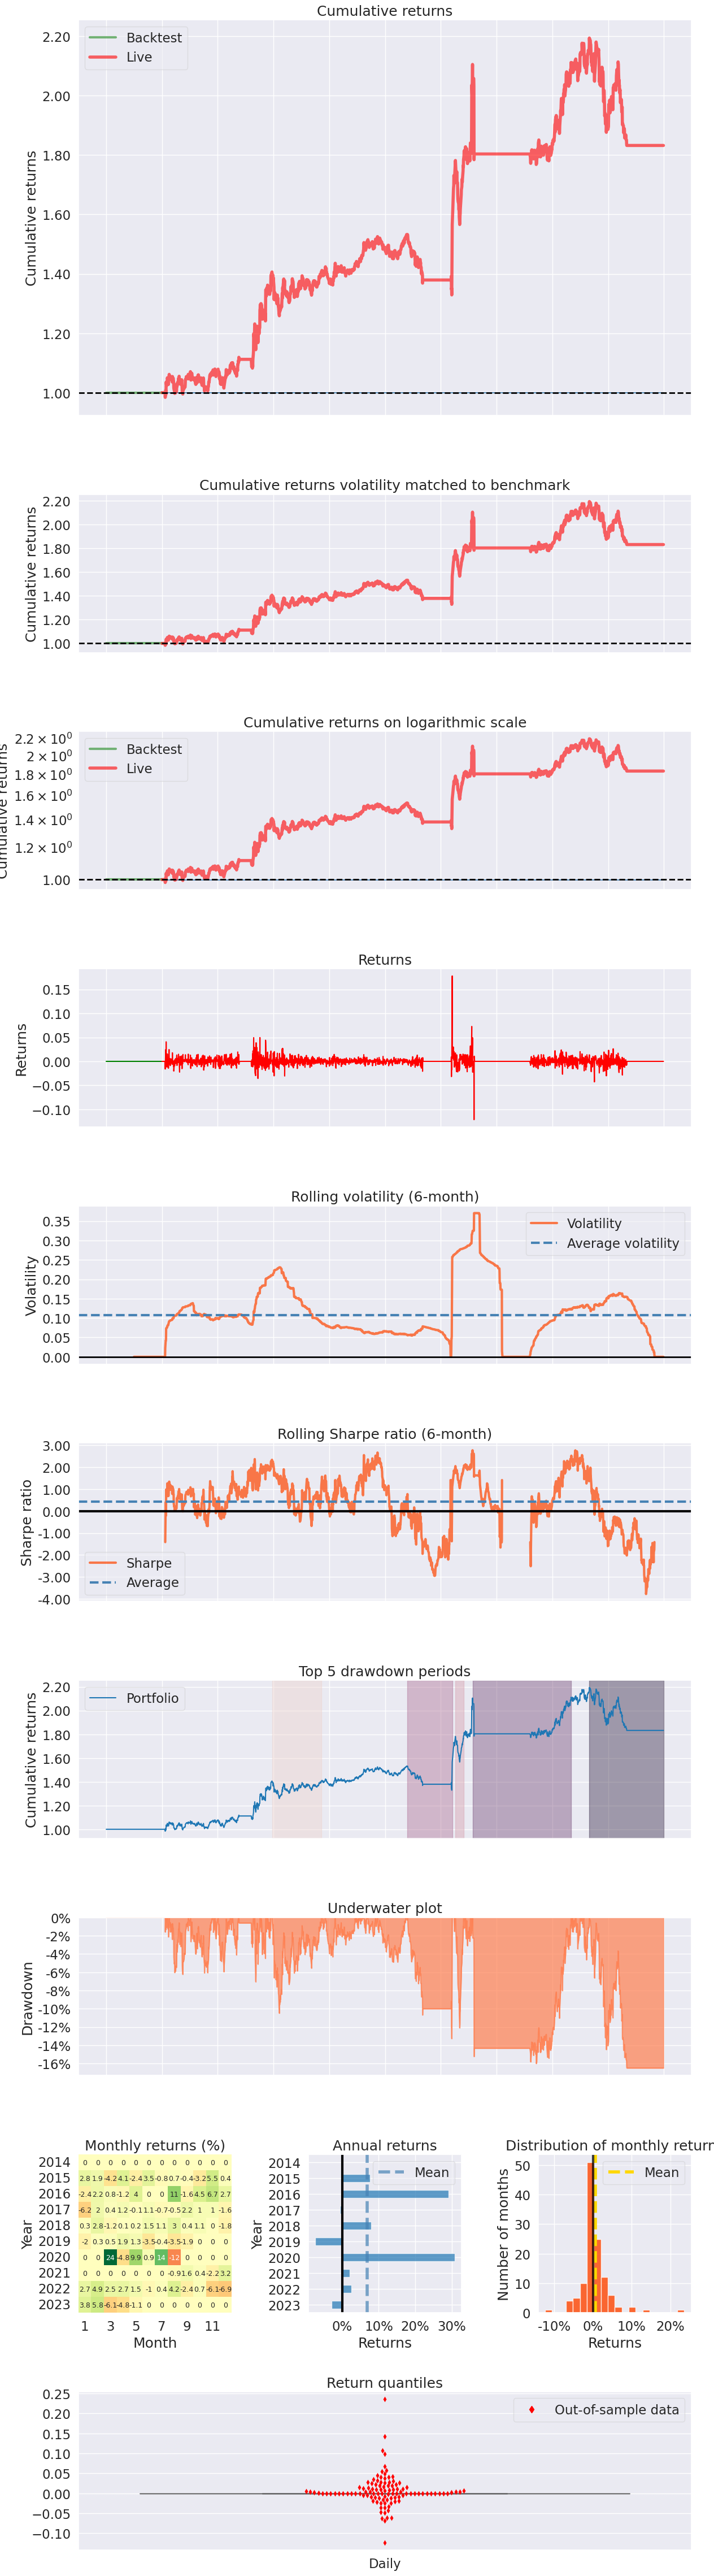

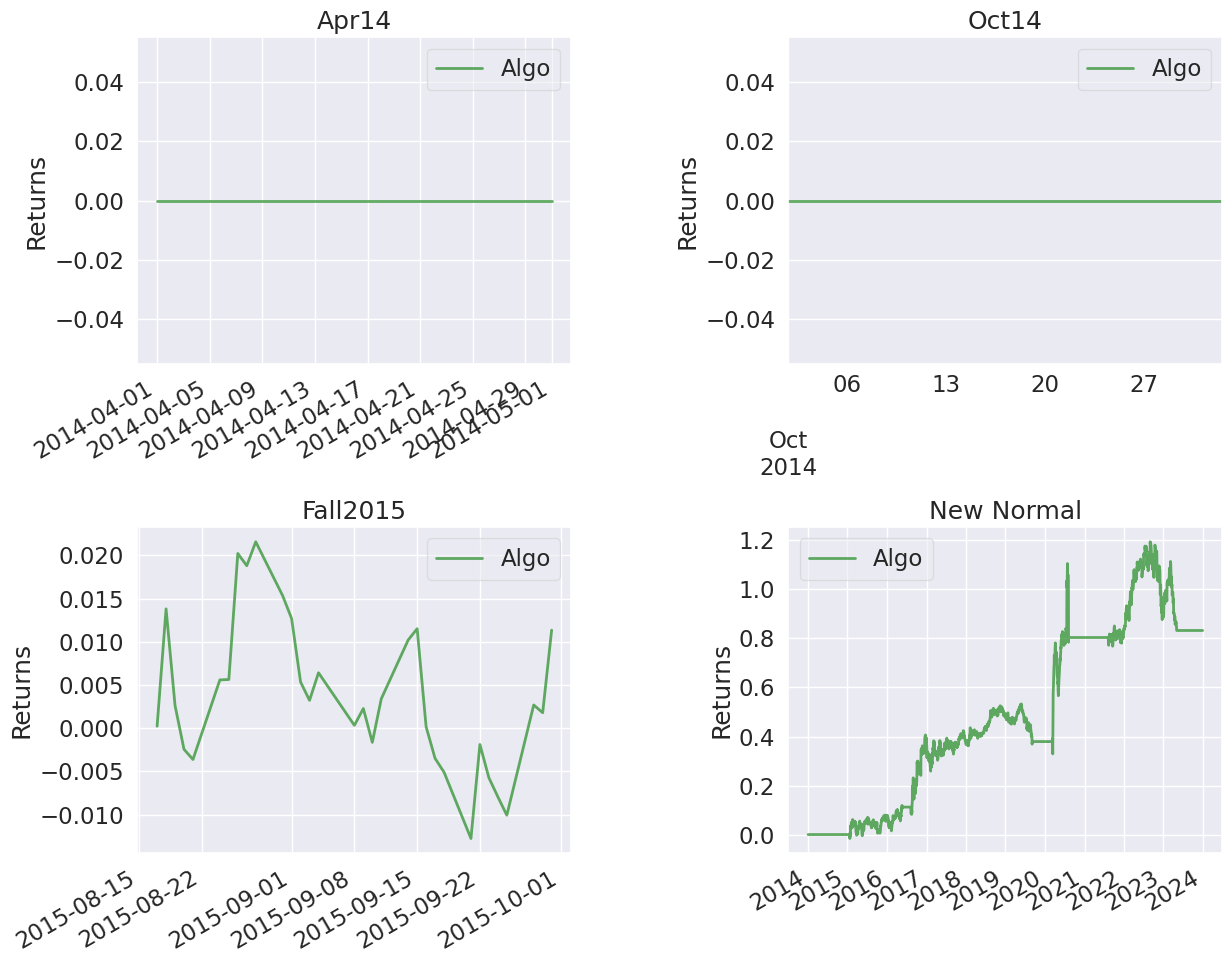

In [9]:
pf.create_full_tear_sheet(returns, live_start_date=stock_dict[stock_list[0]]['Close'].index[obs])